In [1]:
#import tarfile
#tf = tarfile.open("fcp_package.tar.gz")
#tf.extractall()

# 1. Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import re
from datetime import datetime

# nlp pipeline
import spacy

# text analysis
import gensim
from gensim.models import LdaModel, ldamodel
from gensim.models import LsiModel, lsimodel
from gensim.models import Phrases
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.similarities import MatrixSimilarity
import pyLDAvis
import pyLDAvis.gensim 

#Mallet

# visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 2. Options for data vizualisation on screen and Package version

In [3]:
# data vis
%matplotlib inline

# send output to the screen
LINE = ''.join(['\n', 79 * '~', '\n'])

# coding style
print('Coding style as per PEP8', '', end=LINE)


print("""
spaCy version: {}
Gensim version: {}
""".format(spacy.__version__, gensim.__version__))

Coding style as per PEP8 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

spaCy version: 2.2.4
Gensim version: 3.8.3



# 3. Reading the data

In [4]:
# Reading the business level data first
folder = 'brexit'
File0 = 'pr__sus_docs.csv'
File1 = 'pr__sus_attr.csv'
File2 = 'pr__sources.csv'
pr_docs = pd.read_csv(os.path.join(folder,File0))
pr_attr = pd.read_csv(os.path.join(folder,File1))
pr_source = pd.read_csv(os.path.join(folder,File2))

In [5]:
pr_attr.head()

,article,source,variable,value
0,0,0,date,2016-05-04 00:00:00
1,0,0,byline,Anna Murphy
2,0,0,section,"T2;FEATURES; Pg. 6,7"
3,0,0,length,1452
4,1,0,date,2016-05-13 00:00:00


# 4. Cleaning of data

In [6]:
#Transposing the source data and dropping first row
pr_source = pr_source.T
pr_source.drop(pr_source.index[0], inplace=True)

# Adding a source column to source data
pr_source.insert(0, 'source', range(0, 0 + len(pr_source)))

# Renaming the columns
pr_source.columns.values[1] = 'newspaper'

# Merging the source and docs data
df = pd.merge(pr_source, pr_docs, on='source', how='right')

# Dropping source column
df.drop(['source'], axis=1, inplace=True)
df.rename(columns={'newspaper': 'source'}, inplace=True)
# --+ reorganize cols
df = df[['id', 'source', 'text', 'article', 'start', 'sort']]

In [7]:
# slice the attriute data to get the date
pr_date = pr_attr[pr_attr.variable == 'date'].drop(['variable','source'], axis=1)

# the expected timespan is April 23, 2016 - August 23, 2016
pr_timespan = pr_date[(pr_date.value < '2016-08-24 00:00:00') & (pr_date.value >= '2016-04-23 00:00:00')]
# get list of chosen article id
articles = pr_timespan.article.to_list()

# join pr_docs and pr_timespan
df = pd.merge(pr_timespan, pr_docs, on=['article', 'article']).rename(columns={'value':'date'})
df.sort_values('date', inplace=True)

df['date'] = pd.to_datetime(df['date'], utc = True).dt.date

# Merging the text corpora data with attribute date
#df = pd.merge(df, pr_attr,on='article', how='left')

# Dropping redundat columns and renaming source_x
#df.drop(['source_y','variable'],axis=1, inplace=True)
#df.rename(columns={'source_x':'source', 'value':'date'}, inplace=True)

In [8]:
df.head()

,article,date,source,text,start,id,sort
445,647,2016-04-23,3,HIGHLIGHT: Ed Crooks is fascinated by a biogra...,HIGHLIGHT: Ed Crooks is fascinated by a biogra...,180,1
444,646,2016-04-23,3,HIGHLIGHT: \'If China could be persuaded to co...,HIGHLIGHT: \'If China could be persuaded to co...,225,1
443,645,2016-04-23,3,"After months of wrangling, eurozone finance mi...","After months of wrangling, eurozone finance mi...",20,1
442,644,2016-04-23,3,How can the world best combat global warming? ...,How can the world best combat global warming? ...,233,1
446,648,2016-04-26,3,"Zaoui & Co, the tiny European advisory firm se...","Zaoui & Co, the tiny European advisory firm se...",599,1


In [9]:
# Seggregating the data to post brexit referendum period and pre brexit period depending upon the date
# Brexit referendum date is june 23,2016 or 2016-06-23

# Set the Index to be the Date
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d')
df.set_index('date', inplace=True)

# Sort the Data
df = df.sort_values('date')

# Slice the Data to get pre brexit referendum data
To   = '2016-06-22'
df_pre = df.loc[:To,:]

In [10]:
# Slicing the data to find post brexit data
From   = '2016-06-23'
df_post = df.loc[From:,:]

# Understanding prebrexit topics

# 5. NLP pipeline

In [11]:
# docs as list and conversion to lower case
def cleaning(_string):
    # purge non alpha characters
    alpha = re.sub("[^A-Za-z']+", ' ', str(_string))
    return alpha.lower()
                  
# clean text
docs_pre = [cleaning(item) for item in df_pre.text.values]

# hyphen to underscores
docs_pre = [re.sub(r'\b-\b', '_', text) for text in docs_pre]

In [12]:
# load pipeline
nlp = spacy.load('en_core_web_lg', disable=['ner', 'parser', 'tagger'])

In [13]:
# expand on spaCy's stopwords
# my stopwrods
my_stopwords = ['\x1c',
                'ft', 'wsj', 'time', 'sec','year',
                'say', 'says', 'said',
                'mr.', 'mister', 'mr', 'miss', 'ms',
                'inc']
# expand on spacy's stopwords
for stopword in my_stopwords:
    nlp.vocab[stopword].is_stop = True

# 6. Tokenize text

In [14]:
# tokenized text
docs_tokens_pre = []

for doc in docs_pre:
    tmp_tokens = [token.lemma_ for token in nlp(doc) 
                  if not token.is_stop
                  and not token.is_space
                  and not token.is_punct
                  and not token.is_oov
                  and len(token.lemma_) > 1
                  and not token.like_num
                  and not token.like_url
                  and not token.like_email
                  and not token.is_currency]
    docs_tokens_pre.append(tmp_tokens)
    tmp_tokens = []
    
    
# Storing the tokenized text
df_pre.loc[:, 'tkn_text'] = docs_tokens_pre

C:\Users\sachi\anaconda3\envs\SMM694NLP\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\sachi\anaconda3\envs\SMM694NLP\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# 7. Taking into account bi-grams and tri-grams

In [15]:
#Getting rid of common terms
common_terms = [u'of', u'with', u'without', u'and', u'or', u'the', u'a',
                u'not', 'be', u'to', u'this', u'who', u'in']
# find phrases
bigram = Phrases(docs_tokens_pre,
                 min_count=50,
                 threshold=5,
                 max_vocab_size=50000,
                 common_terms=common_terms)

trigram = Phrases(bigram[docs_tokens_pre],
                  min_count=50,
                  threshold=5,
                  max_vocab_size=50000,
                  common_terms=common_terms)

docs_phrased_pre = [trigram[bigram[line]] for line in docs_tokens_pre]

# check nlp pipeline
#print('',
      #'Published abstract:', docs[0],
      #'Tokenized abstract:', docs_tokens[0],
      #'Tri-grammed tokenised abstract:', docs_phrased[0],
     # sep=LINE, end=LINE)

In [16]:
df_pre.head()

,article,source,text,start,id,sort,tkn_text
date,,,,,,,
2016-04-23,647,3,HIGHLIGHT: Ed Crooks is fascinated by a biogra...,HIGHLIGHT: Ed Crooks is fascinated by a biogra...,180,1,"[highlight, ed, crook, fascinate, biography, s..."
2016-04-23,646,3,HIGHLIGHT: \'If China could be persuaded to co...,HIGHLIGHT: \'If China could be persuaded to co...,225,1,"[highlight, china, persuade, construct, energy..."
2016-04-23,645,3,"After months of wrangling, eurozone finance mi...","After months of wrangling, eurozone finance mi...",20,1,"[month, wrangle, eurozone, finance, minister, ..."
2016-04-23,644,3,How can the world best combat global warming? ...,How can the world best combat global warming? ...,233,1,"[world, well, combat, global, warm, people, ta..."
2016-04-26,648,3,"Zaoui & Co, the tiny European advisory firm se...","Zaoui & Co, the tiny European advisory firm se...",599,1,"[co, tiny, european, advisory, firm, set, brot..."


# 8. Topic Modelling

# 8.1 Training the model

In [17]:
# create dictionary and text corpus
dict_pre = Dictionary(docs_phrased_pre)
corpus_pre = [dict_pre.doc2bow(doc) for doc in docs_phrased_pre]

# 8.2 Implementation of LDA algorithm

In [18]:
# Build LDA model with n_topics 20
n_topics = 20
lda_model_pre = gensim.models.ldamodel.LdaModel(corpus=corpus_pre,
                                           id2word=dict_pre,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# View the topics

In [19]:
# Print the Keywors
print(lda_model_pre.print_topics())
doc_lda_pre = lda_model_pre[corpus_pre]

[(0, '0.026*"blend" + 0.008*"fca" + 0.005*"siemens" + 0.003*"mba" + 0.003*"disparity" + 0.002*"dealmakers" + 0.002*"dresser" + 0.002*"misuse" + 0.001*"intern" + 0.001*"filing"'), (1, '0.002*"plaque" + 0.000*"tunisia" + 0.000*"terrorist" + 0.000*"xc" + 0.000*"greece" + 0.000*"terrorism" + 0.000*"tunisian" + 0.000*"uk" + 0.000*"debt" + 0.000*"travel"'), (2, '0.024*"car" + 0.018*"electric" + 0.017*"battery" + 0.016*"jean" + 0.013*"vehicle" + 0.012*"reverend" + 0.012*"biogas" + 0.011*"ltd" + 0.011*"cox" + 0.010*"borough"'), (3, '0.039*"font" + 0.034*"austin_news_deck_web" + 0.029*"uk_asset_font" + 0.029*"url_http_eip_telegraph" + 0.028*"co" + 0.027*"px" + 0.025*"format" + 0.022*"medium" + 0.019*"woff" + 0.019*"italic"'), (4, '0.012*"brand" + 0.011*"good" + 0.009*"people" + 0.008*"design" + 0.008*"feel" + 0.008*"consumer" + 0.008*"thing" + 0.007*"want" + 0.007*"luxury" + 0.007*"palm"'), (5, '0.017*"spencer" + 0.017*"assemble" + 0.015*"judgment" + 0.008*"scent" + 0.007*"fragrance" + 0.007*"p

# Model Evaluation

In [20]:
# The range of coherence values as the number of retained topics change
# define function
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus_pre,
                                               id2word=dict_pre,
                                               num_topics=n_topics, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100)
                                               #passes=10,
                                               #alpha='auto',
                                               #per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
# collect coherence scores as the number of retained topics change
limit,start,step = 20, 1, 1
model_list, coher_vals = compute_coherence_values(dictionary=dict_pre,
                                                  corpus=corpus_pre,
                                                  texts=docs_phrased_pre,
                                                  start=start,
                                                  limit=limit,
                                                  step=step)

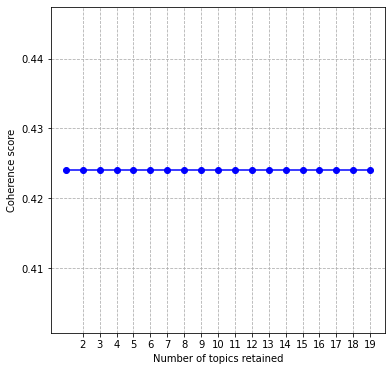

In [22]:
# Coherence scores plot
# data series
x = range(start, limit, step)
y = coher_vals

# create figure
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)

# plot data
ax.plot(x,y, marker='o', color='b', ls='-')

# axes
ax.set_xlabel("Number of topics retained")
ax.set_ylabel("Coherence score")
ax.set_xticks(np.arange(2, 20, 1))

# reference line
#ax.axvline(x=11, ymin=0, ymax=1, color='r')

# grid
ax.grid(True, ls='--')

# save plot to file
folder = 'exhibits'
file = 'pre_1.pdf'
plt.savefig(os.path.join(folder,file),
            transparent=True,
            bbox_inches='tight',
            pad_inches=0)

plt.show()

In [23]:
coher_vals

[0.42410228642505166,
 0.42410228642505166,
 0.42410228642505166,
 0.42410228642505166,
 0.42410228642505166,
 0.42410228642505166,
 0.42410228642505166,
 0.42410228642505166,
 0.42410228642505166,
 0.42410228642505166,
 0.42410228642505166,
 0.42410228642505166,
 0.42410228642505166,
 0.42410228642505166,
 0.42410228642505166,
 0.42410228642505166,
 0.42410228642505166,
 0.42410228642505166,
 0.42410228642505166]

# Model evaluation approach 2

In [24]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_pre.log_perplexity(corpus_pre))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_pre, texts=docs_phrased_pre, dictionary=dict_pre, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.370590596980579

Coherence Score:  0.5017755300520588


In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus_pre, num_topics=num_topics, id2word=dict_pre)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=docs_phrased_pre, dictionary=dict_pre, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

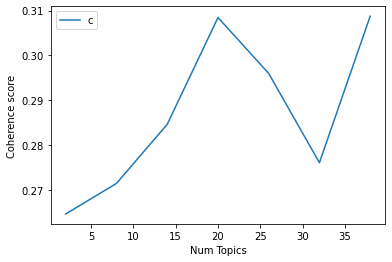

In [26]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dict_pre, corpus=corpus_pre, texts=docs_phrased_pre, start=2, limit=40, step=6)
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

# save plot to file
folder = 'exhibits'
file = 'pre_2.pdf'
plt.savefig(os.path.join(folder,file),
            transparent=True,
            bbox_inches='tight',
            pad_inches=0)
plt.show()

In [27]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2646
Num Topics = 8  has Coherence Value of 0.2714
Num Topics = 14  has Coherence Value of 0.2846
Num Topics = 20  has Coherence Value of 0.3084
Num Topics = 26  has Coherence Value of 0.296
Num Topics = 32  has Coherence Value of 0.276
Num Topics = 38  has Coherence Value of 0.3087


In [28]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

def format_topics_sentences(ldamodel=lda_model_pre, corpus=corpus_pre, texts=docs_pre):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus_pre]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus_pre, texts=docs_pre)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

[(0, '0.006*"company" + 0.005*"service" + 0.004*"investment" + 0.003*"fund" + 0.003*"uk" + 0.003*"food" + 0.003*"people" + 0.003*"new" + 0.003*"work" + 0.003*"eu"'), (1, '0.007*"professor" + 0.007*"service" + 0.006*"company" + 0.004*"government" + 0.004*"xc" + 0.004*"uk" + 0.004*"business" + 0.003*"cent" + 0.003*"price" + 0.003*"co"'), (2, '0.005*"uk" + 0.004*"business" + 0.004*"new" + 0.003*"people" + 0.003*"xc" + 0.003*"service" + 0.003*"eu" + 0.003*"company" + 0.003*"community" + 0.003*"sustainability"'), (3, '0.009*"greece" + 0.008*"service" + 0.005*"country" + 0.004*"fund" + 0.004*"xc" + 0.004*"debt" + 0.004*"eu" + 0.004*"bn" + 0.004*"government" + 0.004*"people"'), (4, '0.005*"fund" + 0.005*"people" + 0.004*"need" + 0.004*"government" + 0.004*"xc" + 0.004*"service" + 0.004*"city" + 0.004*"world" + 0.004*"work" + 0.004*"health"'), (5, '0.013*"service" + 0.005*"community" + 0.004*"people" + 0.003*"need" + 0.003*"child" + 0.003*"government" + 0.003*"xc" + 0.003*"new" + 0.003*"year" 

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,17.0,0.9954,"uk, world, people, business, eu, xc, fund, ser...",highlight ed crooks is fascinated by a biograp...
1,1,17.0,0.9976,"uk, world, people, business, eu, xc, fund, ser...",highlight 'if china could be persuaded to cons...
2,2,3.0,0.9959,"greece, service, country, fund, xc, debt, eu, ...",after months of wrangling eurozone finance min...
3,3,17.0,0.9971,"uk, world, people, business, eu, xc, fund, ser...",how can the world best combat global warming m...
4,4,15.0,0.9960,"service, company, xc, uk, business, new, peopl...",zaoui co the tiny european advisory firm set u...
5,5,18.0,0.9921,"service, uk, work, country, community, busines...",sir caroline binham 's report fca sets out pla...
6,6,17.0,0.9933,"uk, world, people, business, eu, xc, fund, ser...",it has been a little over a year since i began...
7,7,4.0,0.9977,"fund, people, need, government, xc, service, c...",the world 's largest government backed investm...
8,8,15.0,0.4965,"service, company, xc, uk, business, new, peopl...",if we take control we can deliver for our mari...
9,9,17.0,0.5457,"uk, world, people, business, eu, xc, fund, ser...",i am a year old vicar married but as yet no ch...


In [29]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9954,"company, service, investment, fund, uk, food, ...",a surge in chinese bank borrowing for environm...
1,1.0,0.9982,"professor, service, company, government, xc, u...",on a recent thursday night at trendy west holl...
2,2.0,0.8421,"uk, business, new, people, xc, service, eu, co...",jeremy corbyn has drawn a deeper dividing line...
3,3.0,0.9982,"greece, service, country, fund, xc, debt, eu, ...",european officials have agreed to unlock euro ...
4,4.0,0.9990,"fund, people, need, government, xc, service, c...",as australia goes to the polls on july the gre...


In [30]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,17.0,"uk, world, people, business, eu, xc, fund, ser...",7.0,0.0199
1.0,17.0,"uk, world, people, business, eu, xc, fund, ser...",26.0,0.0741
2.0,3.0,"greece, service, country, fund, xc, debt, eu, ...",2.0,0.0057
3.0,17.0,"uk, world, people, business, eu, xc, fund, ser...",31.0,0.0883
4.0,15.0,"service, company, xc, uk, business, new, peopl...",25.0,0.0712
...,...,...,...,...
346.0,1.0,"professor, service, company, government, xc, u...",NaN,NaN
347.0,8.0,"service, work, uk, eu, company, energy, commun...",NaN,NaN
348.0,1.0,"professor, service, company, government, xc, u...",NaN,NaN
349.0,4.0,"fund, people, need, government, xc, service, c...",NaN,NaN


In [31]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_pre, corpus_pre, dict_pre)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.302783  0.067904       1        1  39.590775
10    -0.236730  0.068648       2        1  12.993638
17    -0.220232  0.013524       3        1   8.144639
8     -0.153809 -0.304834       4        1   7.875444
11    -0.230485  0.113108       5        1   7.505473
14    -0.196360  0.136598       6        1   7.081557
9     -0.112446 -0.333822       7        1   6.515551
4     -0.129849  0.065645       8        1   4.178555
19     0.037819  0.036028       9        1   1.537222
12     0.070867  0.065762      10        1   1.400160
3      0.133430  0.007894      11        1   1.246406
2      0.148595 -0.011446      12        1   0.787653
15     0.139532 -0.016649      13        1   0.464535
18     0.160737  0.010161      14        1   0.288233
6      0.158326  0.012784      15        1   0.194277
5      0.156036  0.013444      16        1   0.140366
0      0.148060  0.013821      17        1   0.044823
1      0.143185  0.013806      18        1   0.004593
16     0.143053  0.013812      19        1   0.003079
7      0.143053  0.013811      20        1   0.003024, topic_info=           Term         Freq        Total Category  logprob  loglift
1590    service  2037.000000  2037.000000  Default  30.0000  30.0000
531          eu   468.000000   468.000000  Default  29.0000  29.0000
1392  community   651.000000   651.000000  Default  28.0000  28.0000
342        fund   544.000000   544.000000  Default  27.0000  27.0000
727          uk   724.000000   724.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1938  insurance     0.000323    26.090117  Topic20  -9.5599  -0.8941
1306      quote     0.000323    58.900349  Topic20  -9.5599  -1.7084
699      report     0.000323   211.622101  Topic20  -9.5599  -2.9874
349          go     0.000323   202.387054  Topic20  -9.5599  -2.9427
237       think     0.000323   280.590302  Topic20  -9.5599  -3.2695

[1211 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
6693      8  0.933747         abbey
1991      4  0.975106       academy
1620      1  0.931036        access
1620      7  0.054767        access
5424     10  0.847353  accumulation
...     ...       ...           ...
261       1  0.213699         young
261       3  0.120786         young
261       4  0.603932         young
261       5  0.027874         young
261       7  0.032519         young

[1990 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 11, 18, 9, 12, 15, 10, 5, 20, 13, 4, 3, 16, 19, 7, 6, 1, 2, 17, 8])

In [32]:
# save pyLDAvis data to html file
pyLDAvis.save_html(vis, 'exhibits/topic_modelling_vis.html')

In [33]:
# Finding term to term probabilities
# get top 5 terms per topic
top_terms_line = lda_model_pre.show_topics(num_topics=n_topics, num_words=10)

In [34]:
# rearrange data on top 10 terms per topic
top_terms_m = []

for i in top_terms_line:
    topic_num = i[0]
    prob_terms = i[1].split('+')
    for term_sort, term in enumerate(prob_terms):
        weight = float(term.split('*')[0])
        term = term.split('*')[1].strip('"| ')
        top_terms_m.append([topic_num, term_sort, weight, term])

df_1 = pd.DataFrame(top_terms_m)

# rename columns
old_names = [0, 1, 2, 3]
new_names = ['topic_n', 'term_sort', 'weight', 'term']
cols = dict(zip(old_names, new_names))
df_1.rename(columns=cols, inplace=True)
df_1.set_index(['term_sort', 'topic_n'], inplace=True)
df_1 = df_1.unstack()

# sidewaystable
df_h = pd.DataFrame()

for i in range(10):
    terms = df_1['term'][i]
    weights = df_1['weight'][i]
    weights = pd.Series(['( %s )' % j for j in weights ])
    df_h = pd.concat([df_h, terms, weights], axis=1)

# write data to file
folder = 'exhibits'
file3 = '_1.html'
df_h.T.to_html(os.path.join(folder, file3), index=True)

# Understanding post brexit topics in the press data

In [35]:
# NLp pipeline
# docs as list and conversion to lower case
def cleaning(_string):
    # purge non alpha characters
    alpha = re.sub("[^A-Za-z']+", ' ', str(_string))
    return alpha.lower()
                  
# clean text
docs_post = [cleaning(item) for item in df_post.text.values]

# hyphen to underscores
docs_post = [re.sub(r'\b-\b', '_', text) for text in docs_post]
    
# load pipeline
nlp = spacy.load('en_core_web_lg', disable=['ner', 'parser', 'tagger'])

In [36]:
# expand on spaCy's stopwords
# my stopwrods
my_stopwords = ['\x1c',
                'ft', 'wsj', 'time', 'sec','year',
                'say', 'says', 'said',
                'mr.', 'mister', 'mr', 'miss', 'ms',
                'inc']
# expand on spacy's stopwords
for stopword in my_stopwords:
    nlp.vocab[stopword].is_stop = True

In [37]:
# Tokenize the text
# tokenized text
docs_tokens_post = []

for doc in docs_post:
    tmp_tokens = [token.lemma_ for token in nlp(doc) 
                  if not token.is_stop
                  and not token.is_space
                  and not token.is_punct
                  and not token.is_oov
                  and len(token.lemma_) > 1
                  and not token.like_num
                  and not token.like_url
                  and not token.like_email
                  and not token.is_currency]
    docs_tokens_post.append(tmp_tokens)
    tmp_tokens = []
    
    
# Storing the tokenized text
df_post.loc[:, 'tkn_text'] = docs_tokens_post

C:\Users\sachi\anaconda3\envs\SMM694NLP\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\sachi\anaconda3\envs\SMM694NLP\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [38]:
# Getting rid of bigrams and trigrams

#Getting rid of common terms
common_terms = [u'of', u'with', u'without', u'and', u'or', u'the', u'a',
                u'not', 'be', u'to', u'this', u'who', u'in']
# find phrases
bigram = Phrases(docs_tokens_post,
                 min_count=50,
                 threshold=5,
                 max_vocab_size=50000,
                 common_terms=common_terms)

trigram = Phrases(bigram[docs_tokens_post],
                  min_count=50,
                  threshold=5,
                  max_vocab_size=50000,
                  common_terms=common_terms)

docs_phrased_post = [trigram[bigram[line]] for line in docs_tokens_post]

# check nlp pipeline
#print('',
      #'Published abstract:', docs[0],
      #'Tokenized abstract:', docs_tokens[0],
      #'Tri-grammed tokenised abstract:', docs_phrased[0],
     # sep=LINE, end=LINE)

# Topic modelling

In [39]:
# Training the model
# create dictionary and text corpus

dict_post = Dictionary(docs_phrased_post)
corpus_post = [dict_post.doc2bow(doc) for doc in docs_phrased_post]

In [40]:
# Implementation of LDA 
# Build LDA model with n_topics 20
n_topics = 20
lda_model_post = gensim.models.ldamodel.LdaModel(corpus=corpus_post,
                                           id2word=dict_post,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [41]:
# view the topics
# Print the Keywors
print(lda_model_post.print_topics())
doc_lda_post = lda_model_post[corpus_post]

[(0, '0.031*"university" + 0.022*"london" + 0.019*"airport" + 0.016*"city" + 0.014*"student" + 0.012*"bristol" + 0.010*"www" + 0.010*"campus" + 0.010*"bus" + 0.010*"royal"'), (1, '0.029*"child" + 0.025*"school" + 0.025*"woman" + 0.014*"education" + 0.014*"africa" + 0.013*"health" + 0.007*"community" + 0.007*"action" + 0.007*"development" + 0.007*"protest"'), (2, '0.024*"victoria" + 0.021*"outsource" + 0.012*"depot" + 0.006*"girl" + 0.006*"beer" + 0.005*"spice" + 0.005*"operative" + 0.004*"noise" + 0.004*"youtube" + 0.004*"video"'), (3, '0.018*"eu" + 0.012*"policy" + 0.011*"deficit" + 0.010*"government" + 0.010*"country" + 0.010*"european" + 0.010*"palm" + 0.009*"greece" + 0.009*"growth" + 0.008*"debt"'), (4, '0.046*"px" + 0.033*"component" + 0.033*"html_embed_component_quote" + 0.026*"margin_leave" + 0.014*"quote" + 0.014*"screen" + 0.014*"xc" + 0.014*"medium" + 0.013*"width" + 0.013*"min"'), (5, '0.016*"market" + 0.015*"uk" + 0.014*"ftse" + 0.014*"week" + 0.013*"brexit" + 0.012*"july"

# Model Evaluation

In [ ]:
# collect coherence scores as the number of retained topics change
limit,start,step = 20, 1, 1
model_list, coher_vals = compute_coherence_values(dictionary=dict_post,
                                                  corpus=corpus_post,
                                                  texts=docs_phrased_post,
                                                  start=start,
                                                  limit=limit,
                                                  step=step)

In [ ]:
# Coherence scores plot
# data series
x = range(start, limit, step)
y = coher_vals

# create figure
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)

# plot data
ax.plot(x,y, marker='o', color='b', ls='-')

# axes
ax.set_xlabel("Number of topics retained")
ax.set_ylabel("Coherence score")
ax.set_xticks(np.arange(2, 20, 1))

# reference line
#ax.axvline(x=11, ymin=0, ymax=1, color='r')

# grid
ax.grid(True, ls='--')

# save plot to file
folder = 'exhibits'
file = 'post_1.pdf'
plt.savefig(os.path.join(folder,file),
            transparent=True,
            bbox_inches='tight',
            pad_inches=0)

plt.show()

In [ ]:
# another apporach to evaluate model
# Compute Perplexity
print('\nPerplexity: ', lda_model_pre.log_perplexity(corpus_pre))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_post, texts=docs_phrased_post, dictionary=dict_post, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
# Compute coherence values
model_list, coherence_values = compute_coherence_values(dictionary=dict_post, corpus=corpus_post, texts=docs_phrased_post, start=2, limit=40, step=6)

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

# save plot to file
folder = 'exhibits'
file = 'post_2.pdf'
plt.savefig(os.path.join(folder,file),
            transparent=True,
            bbox_inches='tight',
            pad_inches=0)
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

def format_topics_sentences(ldamodel=lda_model_post, corpus=corpus_post, texts=docs_post):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus_post]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus_post, texts=docs_post)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_1 = pyLDAvis.gensim.prepare(lda_model_post, corpus_post, dict_post)
vis_1

In [ ]:
# save pyLDAvis data to html file
pyLDAvis.save_html(vis, 'exhibits/topic_modelling_post_vis.html')

In [ ]:
# Finding term to term probabilities
# get top 5 terms per topic
top_terms_line = lda_model_pre.show_topics(num_topics=n_topics, num_words=5)

In [ ]:
# rearrange data on top 10 terms per topic
top_terms_m = []

for i in top_terms_line:
    topic_num = i[0]
    prob_terms = i[1].split('+')
    for term_sort, term in enumerate(prob_terms):
        weight = float(term.split('*')[0])
        term = term.split('*')[1].strip('"| ')
        top_terms_m.append([topic_num, term_sort, weight, term])

df_1 = pd.DataFrame(top_terms_m)

# rename columns
old_names = [0, 1, 2, 3]
new_names = ['topic_n', 'term_sort', 'weight', 'term']
cols = dict(zip(old_names, new_names))
df_1.rename(columns=cols, inplace=True)
df_1.set_index(['term_sort', 'topic_n'], inplace=True)
df_1 = df_1.unstack()

# sidewaystable
df_h = pd.DataFrame()

for i in range(10):
    terms = df_1['term'][i]
    weights = df_1['weight'][i]
    weights = pd.Series(['( %s )' % j for j in weights ])
    df_h = pd.concat([df_h, terms, weights], axis=1)

# write data to file
folder = 'exhibits'
file3 = '_2.html'
df_h.T.to_html(os.path.join(folder, file3), index=True)